### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Image Mosaicking #

#### Ananth Sridhar (ananth.sridhar@wisc.edu), Rangapriya Parthasarathy (rparthasarat@wisc.edu), Song Mei (smei4@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model - Mixed Integer Program Formulation](#2.-Mathematical-model---Mixed-Integer-Program-Formulation)
  1. [Similarity Criterion: Pixel Absolute Difference](#2.A.-Similarity-Criterion:-Pixel-absolute-difference)
  1. [Similarity Criterion: Mean Absolute Difference](#2.B.-Similarity-Criterion:-Mean-absolute-difference)
  1. [Similarity Criterion: Mode Absolute Difference](#2.C.-Similarity-Criterion:-Mode-absolute-difference)
  1. [Similarity Criterion: Histogram based Matching](#2.D.-Similarity-Criterion:-Histogram-based-matching)
1. [Solution - Mixed Integer Program Formulation (Julia-Code)](#3.-Solution---Mixed-Integer-Program-Formulation)
  1. [Common Functions](#3.A.-Common-functions)
  1. [Load Images](#3.B.-Load-images)
  1. [Optimization Function](#3.C.-Optimization-function)
  1. [Mosaicking First Image](#3.D.-Mosaicking-first-image)
  1. [More Complicated Image with Image Library](#3.E.-More-complicated-image-with-image-library)
    1. [Brute Force Optimization](#3.E.a.-Brute-force-optimization)
    1. [Split RGB Channel - Speed up our Optimization!](#3.E.b.-Split-RGB-channel---Speed-up-our-Optimization!)
    1. [Histogram based Matching](#3.E.c.-Histogram-based-Matching)
1. [Mathematical Model - Linear Program Formulation](#4.-Mathematical-Model---Linear-Program-Formulation)
1. [Solution - Linear Program Formulation (Julia-Code)](#5.-Solution---Linear-Program-Formulation)
1. [Results and Discussion](#6.-Results-and-discussion)
1. [Conclusion](#7.-Conclusion)
1. [Bonus: Try It Yourself](#8.-Bonus:-try-it-yourself)

## 1. Introduction ##

Mosaicking is an old art technique where pictures or designs are formed by inlaying small bits of colored stone, glass, or tile. These small bits are visible close up, but the boundaries of the bits will blend and a single recognizable image will show at a distance. 

In the modern digital world, this acient art form has been transformed and combined with new technologies. As one has access to large public image database, individual images, instead of pure-colored blocks can be used as tiles to make pictures. Here is a famous mosaic image of president Obama made by [Anne Savage](http://news.siu.edu/2009/01/011509amh9004.php) during his campaign.
![Obama](http://news.siu.edu/_assets/images/2009/01/asavage_mosaic.jpg)
Nearly 6,000 images of individual faces are used to create this image. Sure enough, it has become a very popular poster because of the special art form. Using image mosaicking to form various pictures is very cool and seems like a daunting task because we are picking and arranging thousands of pictures from a even bigger pool of pictures. There are businesses helping you create your own mosaic work with charge. However, with intuition and just a little knowledge of optimization, we can do it at home ourselves!

We know images consist of pixels, and each pixel can be described using RGB color intensities. In order for two images to look alike, we just need to match their pixels. In this case, for the image to show at a distance, intuitively, we can just treat the basis images as "super pixels" and try to match them with the corresponding subimage of the target image. Naturally, we will take the target image and partition it into a grid, where each grid element is our tile size. Then for each grid, we will choose one image from the basis that resembles the most. The way to qualify "resemblance" is discussed in detail in Part II - there are many ways of doing this. This project explores a few different ways of doing this. Because each chosen basis image resembles the grid best, after processing all grids, we will end up with a mosaicking image that overall best resembles the whole image. Notice that this is the most intuitive way to solve the problem, and it will always achieve the best result. We will present the solution using this method in the first section of Part III. This brute force method is limited by its speed; variants of the algorithm that speeds the process up will be discussed. We will also explore how changing the size of the tiles will affect the performance. The image basis in this project are obtained from online source [mazaika](http://www.mazaika.com/mazdownload.html) and generic results from Google Image Search.

**Disclaimer:** All images are property of their respective owners. Their usage in this report is purely educational.

### What will I learn from this report? ###

* How to use Optimization techniques to create Image Mosaics
* Different techniques and the factors that affect the quality of the Image Mosaic
* How to create Image Mosaics with varying "basis" image dimensions
* Extensions to this project that you can try on your own

## 2. Mathematical model - Mixed Integer Program Formulation ##

From the introduction above, it is clear that intuitive approach to image mosaicking is an **assignment problem** which can be modeled as a **Mixed Integer Program**. Let's setup the problem as follows:

* A set of "basis" images - these are the images we will use as tiles to reconstruct the so-called "test" image (which we are trying to reporoduce). The set of "basis" images constitute the set $\mathbf{B}$
* Create a grid of equally sized sub-images from the target image - each sub-image will be a grid element. The smaller we make the grid element, the higher the quality of the resulting mosaic will be. The set of all the grid elements constitute the set $\mathbf{I}$.
  * Of course, the quality also depends on the diversity of colors in our "test" image and the diversity of colors in our "basis" set.
  * The size of the grid elements and the size of the "basis" images must be the same to be consistent (each grid-element is a tile location and each "basis" image is a tile that needs to fit into a tile location). Let this size be represented by $s$.

The **decision variables** $G_i,i\in\mathbf{I}$ ($\mathbf{I}$ is the set of all grid elements in target image) are which image (represented by its index $j\in\mathbf{B}$, where $\mathbf{B}$ is the set of basis images of size $s$) to choose for each grid $i$ of the target image. Therefore, $\mathbf{B}$ represent the restricted set of values $G_i$ can take (in other words, we can choose exactly ONE basis image as the tile to be placed in ONE grid-element). In the mathematical formulation, binary variable for each basis images is introduced to indicate whether a particular basis image is chosen for a grid-element location. For a single grid-element, the variables that indicate assignment of a basis image to that grid-element must satisfy the **SOS constraint** (only one image can be chosen). The **objective** is to minimize the visual difference$^*$ between the chosen mosaic and the target image. Note the difference function should be linear for the model to be MIP.

($^*$ _Several non-linear functions can be used to describe the resemblance of the grid and the basis image and be implemented within special algorithms. But they fall out of the scope of this course and are not discussed here._)

It is worth pointing out that in the current formulation, the optimization of each grid is independent from one another. Therefore, we can lessen the solvers burden by forming a model that solves the sub-problem of optimizing each grid element. To optimize the whole target image, one can simply put the optimization model in a function and call it for each grid element of the image. Let's use the following notation:

* $m$ represents the size of a grid-element along the Y-axis (same as the **height** of a basis image)
* $n$ represents the size of a grid-element along the X-axis (same as the **width** of a basis image)

For grid-element size $m \times n$, each target grid-element can be represented by $m\times n\times 3$ RGB matrix $G$. Before optimization, basis images are pre-processed so that they all have the same size as the grid-elements. Each basis image is represented as $m\times n\times 3$ RGB matrix $B_j,j\in\mathbf{B}$. There are many different ways to quantify the similarity/dis-similarity between any basis and the target sub-image.

In this project, we have limited the grid sizes to $2^p\times 2^p,~p\in\{3,\ldots,6\}$ square grids for the sake of scaling the basis. Further, we make sure the target image can be divided perfectly into integer number of grids. We have explored several different cost functions, and the formulation of each is described below.

Various heuristics to improve the image matching are also explored in the subsequent sections.

### 2.A. Similarity Criterion: Pixel absolute difference

#### Descripton

Minimize the pixel-wise difference between a basis image and a sub-image.

#### Why is this approach NOT the only one worth considering?

This has to do with how our eye processes images. By minimizing the pixel-wise difference, we are doing the algorithmically obvious thing, without any consideration that our eye perceives the image as a whole, which means pixel intensity variations within a region may or may not be significant (it depends on range of intensities in the region, the underlying structure of the image etc.)

Additionally, this approach results in far too many constraints and variables to deal with, which makes this approach practically unreasonable. Mathematically,

$$\text{Number of Constraints} \propto \left( \text{Number of Pixels in Image} \times \text{Number of Basis Images} \right) $$

#### Precomputation

The difference matrix ($m\times n\times 3$) between target $G$ and candidate $B_j$ is

$D_j = G-B_j$

#### Optimization Model (for each grid-element / sub-image)

$\text{minimize}:\qquad\sum_{y=1}^m\sum_{x=1}^n\sum_{c=R,G,B}~~error_{xy,c}$

$\text{subject to}:\qquad error_{xy,c}\geq E[y,x,c]$

$\qquad\qquad\qquad error_{xy,c}\geq -E[y,x,c]$

$\qquad\qquad\qquad E[y,x,c]=\sum_{j=1}^{s}D_j[y,x,c]\cdot p_j$

$\qquad\qquad\qquad \sum_{j=1}^s p_j=1, p_j\in\{0,1\}$

### 2.B. Similarity Criterion: Mean absolute difference

#### Description

Minimize the mean of the pixel-wise difference between each sub-image and basis - a simple attempt at accounting for local variations among the pixels. In other words, this approach is a step towards improving the perceived visual quality of the image mosaic.

#### Optimization Model

$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nG[x,y,c]-\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nB_j[x,y,c],c\in\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1, p_j\in\{0,1\}$


### 2.C. Similarity Criterion: Mode absolute difference

#### Description

Minimize the difference between the mode of the pixel intensities - in other words, try to match the most prominent color in the sub-image in an attempt to get better visual matching. Since making this work across three channels is complicated, this technique is used when we optimize for matching the grayscale versions of the images.

#### Optimization Model

$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=mode(G[:,:,c])-mode(B_j[:,:,c]),c=\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1,p_j\in\{0,1\}$

The first formulation is the most straight forward yet most expensive way. The number of varibles and constraints scales with the size of the target image. Further, by trying to match individual pixels, one may not necessarily get the best performance because mosaicking is more about overall resemblance at a distance. As a result, the optimization model using this objective fuction is not shown in the solution part.

Considering matching individual pixels is very expensive and all we care about is the images look close at a distance. It is straight forward to treat each basis image as a whole. We can extract features from the picture. Two most frequently used are the mean (average) of the pixel RGB intensities and the mode (most frequent value) of the pixel RGB. Both of these are implemented.

### 2.D. Similarity Criterion: Histogram based matching

#### Description

The mode does not capture subtle variations in the color in a sub-image - the histogram paints a far better picture of the color variations within a sub-image, and histogram based matching should be closer to our own visual perception. Whereas a mode tells us only the single most prominent color (which may be useless is a sub-image has equal portions of different colors), a histogram captures this information and let's us match the image better.

#### Optimization Model

$\text{mazimize}:\qquad\sum_{c=R,G,B}~~Correlation_{c} $

$\text{subject to}:\qquad Correlation[c]=\sum_{j=1}^{s}D_j[G,B_j]\cdot p_j$

$\qquad D_j[G,B_j]=\dfrac{\sum_{j=1}^{s}~~\Big[\Big(Hist(G[:,:,c])-Mean{(Hist(G[:,:,c])}\Big)\Big(Hist(B_j[:,:,c])-Mean{(Hist(B_j[:,:,c])}\Big)\Big]}{\sqrt{\sum_{}~~(Hist(G[:,:,c])-Mean{(Hist(G[:,:,c])))^2}}\sqrt{\sum_{j=1}^{s}~~(Hist(B_j[:,:,c])-Mean{(Hist(B_j[:,:,c])))^2}}},c=\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1,p_j\in\{0,1\}$

Histograms helps us capture an overall sense of the lightness and darkness and the amount of contrast of the image. In an image, I, I(x,y) represents the intensity at pixel with coordinates (x,y). The histogram h, as h(i) indicates that intensity i, appears h(i) times in the image. Mathematically, 
$\qquad\qquad\qquad\qquad\qquad h(i)=\sum_{x}\sum{y}~~I(x,y)=i$


We have also utilized histograms to compare each basis image $B_j$ with target grid $G$. This would essentially boil down to comparing two arrays of data. We have used correlation as the comparison metric for comparing the two arrays. **Correlation** is given by, 

$\qquad\qquad\qquad d(H_1,H_2)=\dfrac{\sum_{k}^{s}~~\Big[\Big(H_1(k))-\overline{H_1}\Big)\Big(H_2(k))-\overline{H_2}\Big)\Big]}{\sqrt{\sum_{k}~~\Big(H_1(k))-\overline{H_1}\Big)^2}\sqrt{\sum_{k}~~\Big(H_2(k))-\overline{H_2}\Big)^2}},\overline{H_i}=\dfrac{1}{N}\sum_{k=1}^{N} ~~H_i(k)$

Larger the distance metric, better the match. Perfect match would be $d(H_1,H_2)=1$. 

Therefore, the objective function in our problem is to maximize the correlation between the histograms of the target grid $G$ and the basis image $B_j$. This can be done both using the grayscale image and an RGB image. In the case of a grayscale image, the grayscale histograms of $G$ and $B_j$ are compared and in the case of an RGB image, the votes obtained for each intensity in each channel is summed in both $G$ and $B_j$ and then the correlation between the corresponding two arrays of data is maximized. Both these cases are implemented.

## 3. Solution - Mixed Integer Program Formulation ##

**IMPORTANT:** Please run all the cells sequentially

### 3.A. Common functions
The following module contains all the helper functions to process the images. Run this section first before moving on to the optimization model.

In [3]:
## There is a warning that appears when loading common_functions because of one of
##    the packages we import. Please ignore the warnings, or run this cell twice to
##    hide the warnings
using Images, DataFrames, FixedPointNumbers, PyPlot, Colors, ProgressMeter
using JuMP, Clp, Mosek

include("common_functions.jl");

### 3.B. Load images
This section contains the sample preparation work before mosaicking image. Loading the test images, loading the basis images, and scaling the basis images to the desired size. These will be copied and properly modified in following sections when we do different mosaickings.

In [4]:
# load target images
test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded");

5 test image files loaded


### 3.C. Optimization function

**The optimization of a single grid element put in a function, using JuMP. Function pickOpt() uses approaches 2.B and 2.C (mean and mode of the image).**

In [8]:
function pickOpt(sub_test_image, basis_colors, optimize_color)
    ## function that picks the optimal basis image for one sub-image of the same size
    ## inputs: sub_test_image, the sub-image we are trying to optimize, same size as the desired basis
    ##         basis_colors, the mode/mean array of basis library depending on optimize_color
    ##         optimize_color, logical variable choosing the mean absolute difference (F) 
    ##         or mode absolute difference (T)
    
    # get number of basis library and the number of channels we are optimizing
    n_basis = size(basis_colors, 1)
    n_colors = size(basis_colors, 2)
    
    m = Model(solver = MosekSolver()) # optimization model
    @variable(m, pick_basis[1:n_basis], Bin) # one binary varible for each basis image, indicating whether it is chosen
    @variable(m, AbsMatchError[1:n_colors] >= 0) # absolute difference
        
    @constraint(m, sum(pick_basis) == 1) # SOS constraint, only one image can be picked
        
    test_image_value = nothing 
    if optimize_color # calculate the mode/mean value for each basis image
        test_image_value = [ mode(sub_test_image[:,:,color]) for color in 1:n_colors ]
    else
        test_image_value = [ mean(sub_test_image[:,:,color]) for color in 1:n_colors ]
    end
    
    @expression(m, MatchError[color in 1:n_colors], test_image_value[color] - 
                                                    sum(dot(pick_basis,basis_colors[:,color])) )
    @constraint(m, MatchError .<=  AbsMatchError)
    @constraint(m, MatchError .>= -AbsMatchError)
        
    @objective(m, Min, sum(AbsMatchError)) # minimize the absolute error
        
    status = solve(m)
    # show some output to communicate that things are moving forward
    opt_pick_basis = getvalue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

**Function pickOptHist() uses approaches 2.D.**

In [10]:
function pickOptHist(sub_test_image,optimize_color,n_basis,hist_basis_mat)
    ## function that picks the optimal basis image for one sub-image of the same size 
    ##          using the histogram similarity criterion
    ## inputs: sub_test_image, the sub-image we are trying to optimize, same size as the desired basis
    ##         optimize_color, logical variable choosing the mean absolute difference (F) 
    ##                         or mode absolute difference (T)
    ##         n_basis, number of basis images in the library
    ##         hist_basis_mat, matrix storing the precalculated histogram of images in the library
        
    # get number of basis library and the number of channels we are optimizing
    corr = zeros(n_basis,1)
    m = Model(solver = MosekSolver(LOG=1)) # optimization model
    @variable(m, pick_basis[1:n_basis], Bin)# one binary varible for each basis image, indicating whether it is chosen
    @variable(m,test_image_hist_mean>=0) # used to calculate the histogram of the test image
    @constraint(m, sum(pick_basis) == 1)# SOS constraint, only one image can be picked
    if optimize_color # calculate for RGB
        (nothing,test_image_hist1) = hist(vec(sub_test_image[:,:,1]),-1:255)
        (nothing,test_image_hist2) = hist(vec(sub_test_image[:,:,2]),-1:255)
        (nothing,test_image_hist3) = hist(vec(sub_test_image[:,:,3]),-1:255)
        test_image_hist=test_image_hist1+test_image_hist2+test_image_hist3
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
        else # calculate for the mean value
        (nothing,test_image_hist) = hist(vec(sub_test_image[:,:,1]),-1:255)
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
    end
    
    for basis in 1:n_basis # calculate correlation of the test image with each basis
        corr_num=(sum(test_image_hist_mean.*hist_basis_mat[basis]))
        corr[basis]=sum(corr_num/((sqrt(sum(test_image_hist_mean.^2))).*sqrt(sum(hist_basis_mat[basis].^2))));
    end
    
    #Check if value is NaN
    for basis in 1:n_basis
        if isequal(corr[basis],NaN)
            corr[basis]=0
        end
    end
    
    @expression(m, Correlation, sum(dot(pick_basis,corr[:])))
    @objective(m, Max, Correlation) # maximize correlation to get best match
        
    status = solve(m)
    # return the basis of choosing
    opt_pick_basis = getvalue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

### 3.D. Mosaicking first image
Let us try mosaicking our first image. Target is a black and white QR code image, and we choose the gray scale image set. Should be able to get the exact picture back with small enough basis images. In this part, we do things the [brute force](3.E.a.-Brute-force-optimization) way. Function brute_force() wraps everthing needed to be done in a function.
 
#### Settings

In [20]:
test_image = test_images_mat[1] # qr code
image_files = get_image_files("./grayscale") # load gray scale library
base_size = 8 # choose base_size
optimize_color = true # choose optimizing mean (F) or mode (T)

# load data
images_mat = load_images_as_cellarray_mats(image_files)
println(length(images_mat), " basis image files loaded.");

4 basis image files loaded.


In [21]:
function brute_force(test_image, images_mat, base_size, optimize_color)
    ## compact function that uses the brute force mosaicking, return the assembled image
    ## inputs: test_image, the image we are trying to mosaic in cellarray form
    ##         images_mat, the image library loaded in cellarray form
    ##         base_size, number of pixels along the width of the square base
    ##         optimize_color, logical variable, choose whether we use mean absolute difference (F)
    ##                         or mode absolute difference (T)
    
    # scale the library based on the desired size from input
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    # get dimensions 
    n_basis = length(images_mat) # number of basis images
    w_basis = size(images_mat[1], 2) # basis width
    h_basis = size(images_mat[1], 1) # basis height
    w_test_image = size(test_image, 2) # target width
    h_test_image = size(test_image, 1) # target height
    n_basis_width = div(w_test_image, w_basis) # number of basis images needed to fill target width
    n_basis_height = div(h_test_image, h_basis) # number of basis images needed to fill target height

    # prepare some arrays for storage
    basis_colors = nothing
    n_colors = nothing
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = similar(test_image)

    @showprogress 1 for j = 1:n_basis_height # loop over all subimages
        for i = 1:n_basis_width
            # pick out the target grid
            sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
            if optimize_color # use mode absolute difference 
                n_colors = 3
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                    end
                end
            else # use mean absolute difference 
                n_colors = 1
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                    end
                end
            end
            
            chosen_basis = pickOpt(sub_test_image, basis_colors, optimize_color) # call optimization fucntion for the subimage
            basis_choice[j,i] = chosen_basis
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
        end
    end
    return mosaic_image
end;

Progress: 100% Time: 0:00:19


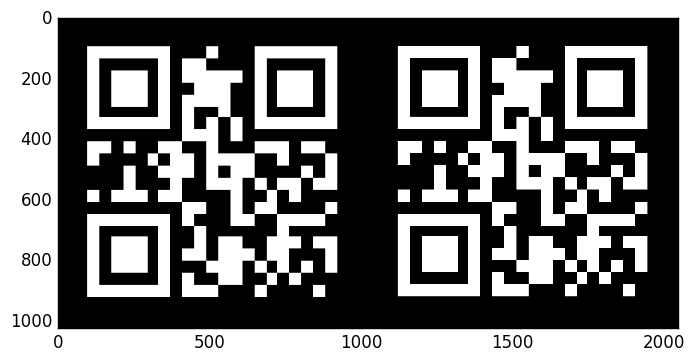

In [22]:
mosaic_image = brute_force(test_image, images_mat, base_size, optimize_color);
imshow([test_image mosaic_image]);

### 3.E. More complicated image with image library
In this section, we are optimizing a real image with one of our libraries. We first solve the problem using the brute force way. Then several improvement are explored. Here is the image we are mosaicking.


#### 3.E.a. Brute force optimization
The brute force way means we do the optimization for each grid the same way using the function in section [3.C.](#3.C.-Optimization-function) without any heuristics / prior processing. The following section loads the basis and rescale it to the desired size.
Functions brute_force() utilizes the optimization functions pickOpt() shown above and return the mosaic image. For description of inputs, please see the comments in the cells.

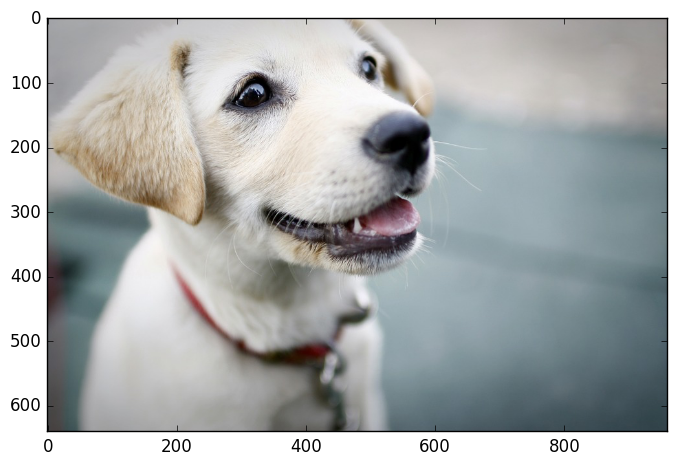

In [14]:
test_image = test_images_mat[2]; # dog
imshow(test_image);

In [17]:
image_files = get_image_files("./music0500") # image library with ~500 album covers
base_size = 8
optimize_color = true

# load data
images_mat = load_images_as_cellarray_mats(image_files)
println(length(images_mat), " basis image files loaded.")

498 basis image files loaded.


Progress: 100% Time: 0:05:32


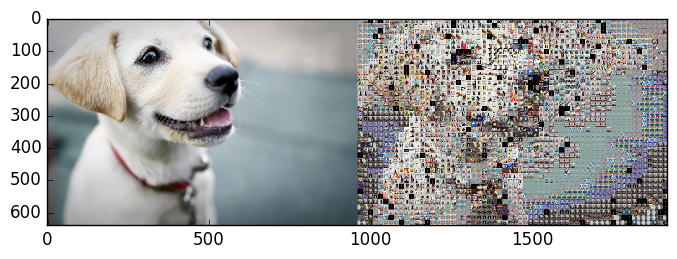

In [40]:
# try mosaick the image the brute force way
mosaic_image = brute_force(test_image, images_mat, base_size, optimize_color);
imshow([test_image mosaic_image]);

#### 3.E.b. Split RGB channel - Speed up our Optimization!
Notice the brute force way is very slow because the SOS constraint has the size of the whole basis array for each sub-problem. Further, the result is not very satisfying at some points. It is worth noting that smallest $L_1$ norm does not necessarily guarantee similar color appearance. For example at the lower right corner, the brownish basis is chosen for the dark blue regions. To address this, we can preprocess both the grid and basis images by identifying the dominant color. The simple way is to find the color with the largest average intensity. By doing this, we roughly reduces the basis size for each sub-problem to $\frac{1}{3}$ of the original basis size. Additionally, we guarantee the basis image we choose for each grid has the same dominant color as the grid itself.

Function **split_rgb()** wraps everything needed for this method into one function.

In [23]:
function split_rgb(test_image, images_mat, base_size, optimize_color)
    ## compact function that uses the splitting rgb speed up, return the assembled image
    ## inputs: test_image, the image we are trying to mosaic in cellarray form
    ##         images_mat, the image library loaded in cellarray form
    ##         base_size, number of pixels along the width of the square base
    ##         optimize_color, logical variable, choose whether we use mean absolute difference (F)
    ##                         or mode absolute difference (T)
    
    # scale the library based on the desired size from input
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    
    # declare the 3 channels and split the scaled library into 3 channels
    images_r = similar(images_mat)
    images_g = similar(images_mat)
    images_b = similar(images_mat)
    count=split_channel(images_mat,images_r,images_g,images_b)
    images_r = images_r[1:count[1]]
    images_g = images_g[1:count[2]]
    images_b = images_b[1:count[3]]
    
    # get dimensions 
    n_basis = length(images_mat) # number of basis images
    w_basis = size(images_mat[1], 2) # basis width
    h_basis = size(images_mat[1], 1) # basis height
    w_test_image = size(test_image, 2) # target width
    h_test_image = size(test_image, 1) # target height
    n_basis_width = div(w_test_image, w_basis) # number of basis images needed to fill target width
    n_basis_height = div(h_test_image, h_basis) # number of basis images needed to fill target height
    
    # prepare some arrays for storage
    basis_colors = nothing
    n_colors = nothing
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = similar(test_image)

    @time @showprogress 1 for j = 1:n_basis_height # loop over all sub images
        for i = 1:n_basis_width
            # pick out the target grid
            sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
            # find the channel of the sub-image and choose the corresponding basis for optimization
            channel = find_channel(sub_test_image)
            if (channel == 1)
                images_base = images_r
            elseif (channel == 2)
                images_base = images_g
            else
                images_base = images_b
            end
            n_basis = size(images_base)[1] # the basis size of the specific channel
            if optimize_color # optimize mean absolute difference
                n_colors = 3
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mode(images_base[basis][:,:,color])
                    end
                end
            else # optimiza mode absolute difference
                n_colors = 1
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mean(images_base[basis][:,:,:])
                    end
                end
            end
            chosen_basis = pickOpt(sub_test_image, basis_colors, optimize_color)
            basis_choice[j,i] = chosen_basis
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = copy(images_base[chosen_basis])
        end
    end

    return mosaic_image
end;

Progress: 100% Time: 0:00:21
 20.705582 seconds (11.57 M allocations: 707.089 MB, 1.84% gc time)


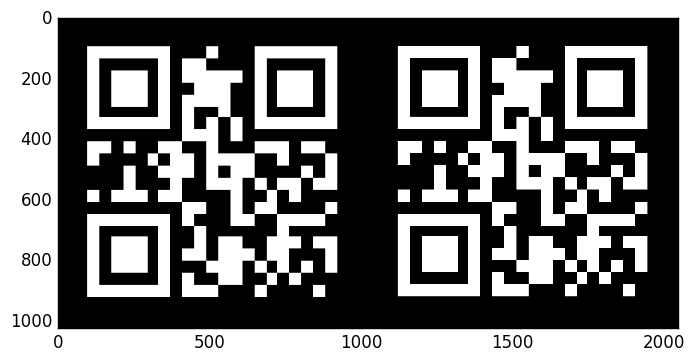

In [24]:
mosaic_image = split_rgb(test_image, images_mat, base_size, optimize_color);
imshow([test_image mosaic_image]);

#### 3.E.c. Histogram based Matching
Another method which was previously discussed was using Histogram matching to match the target grid with the best match from the basis set. This gives a smoother result compared to previous methods discussed above. The total number of bins used has not been quantized here. We have used 256 bins each for 0 - 255 intensities.Two more helper functions are added for this method. 

Function **histogram_optimization()** wraps everything needed in the method into a function.

In [25]:
test_image = test_images_mat[2] # qr code
image_files = get_image_files("./grayscale")
base_size = 8
optimize_color = true

# load data
images_mat = load_images_as_cellarray_mats(image_files)
println(length(images_mat), " basis image files loaded.");

4 basis image files loaded.


In [26]:
function histogram_optimization(test_image,images_mat,base_size,optimize_color)
    ## function that uses histogram matching to return the assembled image
    ## inputs: test_image, the image we are trying to mosaic in cellarray form
    ##         images_mat, the image library loaded in cellarray form
    ##         base_size, number of pixels along the width of the square base
    ##         optimize_color, logical variable, choose whether we want to perform mosaicing on 
    ##                         a color image (T) or grayscaled image (F)
    
   
    image_files=load_cellarray_mats_as_images(images_mat)
    
    images_gray_mat=rgb2gray(image_files)
    # scale the library based on the desired size from input
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    
    test_image_temp = cell(1,1)
    test_image_temp[1] = convert_mat_to_image(test_image)
    test_image_gray = rgb2gray(test_image_temp)[1]
    
    # get dimensions 
    n_basis = length(images_mat) #Number of basis images
    w_basis = size(images_mat[1], 2) #Basis width
    h_basis = size(images_mat[1], 1) #Basis height
    w_test_image = size(test_image, 2) #Target image's width
    h_test_image = size(test_image, 1) #Target image's height

    n_basis_width = round(Int64, w_test_image/w_basis) #Number of basis images needed to fill target width
    n_basis_height = round(Int64, h_test_image/h_basis) #Number of basis images needed to fill target height

    #Initialize required arrays
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = copy(test_image)
    hist_basis_mat = cell(n_basis,1)
    hist_basis_mat1 = cell(n_basis,1)
    hist_basis_mat2 = cell(n_basis,1)
    hist_basis_mat3 = cell(n_basis,1)

    test_image1=rand(Int64,size(test_image,1),size(test_image,2),size(test_image,3))
    images_mat1 = cell(length(images_mat),1)
    test_image_gray1=rand(Int64,size(test_image_gray,1),size(test_image_gray,2),size(test_image_gray,3))
    images_gray_mat1 = cell(length(images_gray_mat),1)
    for basis in 1:n_basis
        images_mat1[basis]=
        rand(Int64,size(images_mat[basis],1),size(images_mat[basis],2),size(images_mat[basis],3))
     
    end
    for basis in 1:n_basis
        images_gray_mat1[basis]=rand(Int64,size(images_gray_mat[basis],1),
                                           size(images_gray_mat[basis],2), size(images_gray_mat[basis],3))
    end
    #Convert Hexadecimal intensity values to Int values for easy computation of Histogram
    test_image1 = convert_image_mat_to_Int64(test_image)
    test_image_gray1=convert_image_mat_to_Int64(test_image_gray)
    for basis in 1:n_basis
        images_mat1[basis]=convert_image_mat_to_Int64(images_mat[basis])
        images_gray_mat1[basis]=convert_image_mat_to_Int64(images_gray_mat[basis])
    end
    
    @showprogress 1 for j = 1:n_basis_height #loop over all sub images
        for i = 1:n_basis_width

           if optimize_color
                # pick out the target grid
                sub_test_image = test_image1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]
                    for basis in 1:n_basis
                    # Find histogram of Channel 1(Red)
                    (a,hist_basis_mat1[basis]) = hist(vec(images_mat1[basis][:,:,1]),-1:255) 
                    # Find histogram of Channel 2(Green)
                    (a,hist_basis_mat2[basis]) = hist(vec(images_mat1[basis][:,:,2]),-1:255) 
                    # Find Histogram of Channel 3(Blue)
                    (a,hist_basis_mat3[basis]) = hist(vec(images_mat1[basis][:,:,3]),-1:255)
                    hist_basis_mat[basis]= hist_basis_mat1[basis]+hist_basis_mat2[basis]+hist_basis_mat3[basis]
                    hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])
                    end
           else 
                 # pick out the target grid
                sub_test_image = test_image_gray1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]  
                for basis in 1:n_basis
                    #Find histogram of one channel
                    (a,hist_basis_mat[basis]) = hist(vec(images_gray_mat1[basis]),-1:255) 
                    hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])

                end  
            end
                chosen_basis = pickOptHist(sub_test_image,optimize_color,n_basis,hist_basis_mat)
             basis_choice[j,i] = chosen_basis

             if optimize_color
                mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]

            else
                mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis),:] = images_gray_mat[chosen_basis]
            end      

        end
    end
    
    if optimize_color
         
        return mosaic_image, test_image
    else
        return mosaic_image, test_image_gray
    end
    
end;

#### In the case of a color image

Progress: 100% Time: 0:00:08


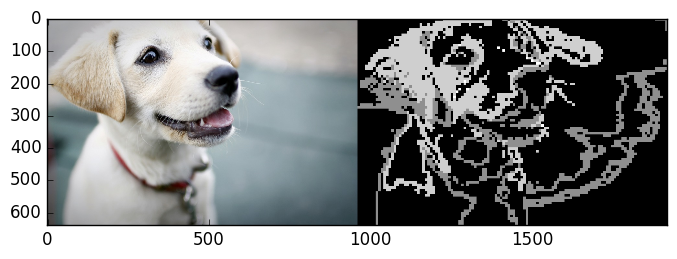

In [21]:
optimize_color = true;
mosaic_image, test_image_used = histogram_optimization(test_image, images_mat, base_size, optimize_color);
imshow([test_image_used mosaic_image]);

#### In the case of a grayscale image

Progress: 100% Time: 0:00:06


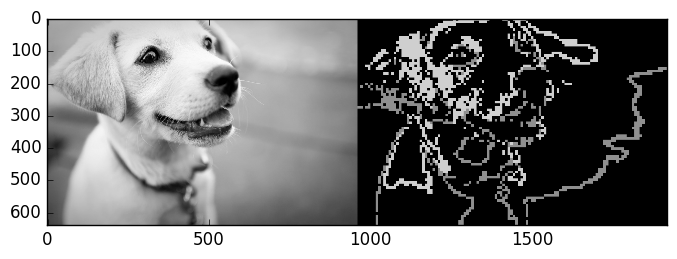

In [22]:
optimize_color = false;
mosaic_image, test_image_used = histogram_optimization(test_image, images_mat, base_size, optimize_color);
imshow([test_image_used mosaic_image]);

## 4. Mathematical Model - Linear Program Formulation

So far, we have only been able to work with fixed basis sizes. What if we wanted to create a mosaic where we could also optimize to choose the best size of the tiles and have a mosaic image that is composed of tiles of varying sizes?

For this approach, given its inherent complexity, a Linear Program formulation with heavily pre-processed data could be practically feasible, and such an approach is presented below.

We choose a desired downscaling level for the basis images (the downscaling happens in factors of 2). For example:

* Input Basis Images - Size - 64 x 64
* Desired Downscaling : 3
* The sizes that will be considered are:
  * Downscaling 1: 64 x 64
  * Downscaling 2: 32 x 32
  * Downscaking 3: 16 x 16

The optimization will try to pick the best combination of the basis image as well as the best size possible and create an image using that.

**NOTE:** Setting desired downscaling to 1 will result in a Linear Program formulation for a fixed basis size

### Important Warning

Unfortunately, the amount of pre-processing memory this approach needs scales quadratically with each dimension of the target image, exponentially with the desired downscaling and linearly with the number of basis images. This results in any desired downcaling value beyond 3 impractical on our personal computers (a computer with about 40-50 GB of RAM can handle it). The minimum amount of memory required on the system is displayed during the calculations below.

### Objective

Here we are only minimizing the mean error between the pixels to minimize the already high computational effort while pre-processing.

### Preprocessing

We pick the smallest downscaled image based on the desired downscaling setting (let's say this is 16 x 16). Let's say that the test image is of size 640 x 640. This would mean the smallest grid elements would be 16 x 16 and the grid of the smallest basis images itself would be 40 x40 to cover the entire image. These 40 x 40 smallest elements are our grid elements.

For basis images that are not scaled down to this level, they will span more than one grid element. For example, a 32 x 32 downscaled basis image will span **4** grid elements of size 16 x 16, in the following way:

| $\dots$ | $\dots$ | $\dots$ | $\dots$ |
|:--:|:--:|:--:|:--:|
| $\dots$ |**16 x 16** | **16 x 16** | $\dots$ |
| $\dots$ | **16 x 16** | **16 x 16** | $\dots$ |
| $\dots$ | $\dots$ | $\dots$ | $\dots$ |

The preprocessing step does the following:
* **For every downscaling settings (1 --> desired)**
  * For every basis image
    * **For every position of the downscaled basis image in the grid**
      * Compute the mean absolute pixel intensity error and store it in a matrix
      
This processing is done by the compute_mean_errors function below. The result of the precomputation is a matrix, which is described below.

$\text{mean_error}\left[ \text{grid_loc_y}\ ,\ \text{grid_loc_x}\ ,\ \text{basis_loc_y}\ ,\ \text{basis_loc_x}\ ,\ \text{color}\  ,\ \text{downscaling}\ ,\ \text{basis} \right]$

#### Explanation

* grid_loc_y : Location of the grid element on the Y-axis
* grid_loc_x : Location of the grid element on the X-axis
* basis_loc_y : Location of the top-left corner of the basis image on the Y-axis
* basis_loc_x : Location of the top-left corner of the basis image on the X-axis
* color : The Color Channel (R/G/B)
* downscaling : The factor by which the basis image has been scaled down
* basis : The index of the basis image from the basis set $\mathbf{B}$

grid_loc_y and grid_loc_x are needed because if a basis image is not downscaled to the maximum level, it can be located in multiple places and still affect the error in the same grid-element. This arises from the fact that a basis image that is not completely downscaled spans multiple grid elements, as explained above. So the mean_error value is available for every legal combination of a grid-element, basis location, its scale, color channel and basis image.

During the optimization, the restriction that only one basis image can cover any particulat grid element is imposed, giving rise to the unit hypercube.

### Why does an LP work (giving integer solutions)?

The only constraints used in this model have vertices on the unit hypercube - consequently the solution has to be at a vertex, giving rise to integer solutions.

### Optimization Model

minimize: $\sum_{\text{grid elements}} \left[ \text{mosaic error} + \lambda \times \text{number of downscaled basis images} \right]$

where:

* $\lambda$ : tradeoff parameter between decreasing mosaic error and doing more downscaling
* $\text{mosaic error}[\text{grid_loc_y}, \text{grid_loc_x}] = \sum_{\text{basis locations}} \sum_{\text{downscaling}} \sum_{\text{basis images}} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad \text{mean}_{\text{colour}}\left( \text{mean_error}\left[ \text{grid location}\ ,\ \text{basis location}\ ,\ \text{downscaling}\ ,\ \text{basis image} \right]  \times \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad \text{place_basis}[\text{basis location}, \text{downscaling}, \text{basis image}] \right) $

subject to: **For each grid location**

$$ \sum_{\text{possible basis images, locations, scales for this grid location }} \text{place_basis}\left[\text{basis location}, \text{downscaling}, \text{basis image}\right] = 1$$

## 5. Solution - Linear Program Formulation ##

In [5]:
test_image = test_images_mat[5] # wisconsin state capitol
image_files = get_image_files("./small_set")
desired_downscaling = 3

# load data
images_mat = load_images_as_cellarray_mats(image_files)
println(length(images_mat), " basis image files loaded.");

In [7]:
# load data
images_mat = load_images_as_cellarray_mats(image_files)

println(length(images_mat), " basis image files loaded")

max_downscaling_height = floor( log2(size(images_mat[1],1)) )
max_downscaling_width = floor( log2(size(images_mat[1],2)) )

downscaling = round(Int, min(desired_downscaling, max_downscaling_height, max_downscaling_width))

n_basis = length(images_mat)
h_test, w_test, n_colors = size(test_image)
h_basis, w_basis, n_colors = size(images_mat[1])
    
h_basis_smallest = div(h_basis, 2^(downscaling-1))
w_basis_smallest = div(w_basis, 2^(downscaling-1))
    
h_grid_test_image = div(h_test, h_basis_smallest)
w_grid_test_image = div(w_test, w_basis_smallest)

println("n_basis = ", n_basis)
println("h_test, w_test, n_colors = ", (h_test, w_test, n_colors) )
println("h_basis, w_basis, n_colors = ", (h_basis, w_basis, n_colors) )
println("h_basis_smallest, w_basis_smallest = ", (h_basis_smallest, w_basis_smallest) )
println("h_grid_test_image, w_grid_test_image = ", (h_grid_test_image, w_grid_test_image) )
println("downscaling = ", downscaling)

memory_needed = (h_grid_test_image * w_grid_test_image * (2^downscaling-1)^2 * n_colors * downscaling * n_basis * 2) / 1e9 # GB
println("Memory Needed = ", memory_needed, " GB")

4 basis image files loaded
n_basis = 4
h_test, w_test, n_colors = (640,960,3)
h_basis, w_basis, n_colors = (64,64,3)
h_basis_smallest, w_basis_smallest = (16,16)
h_grid_test_image, w_grid_test_image = (40,60)
downscaling = 3
Memory Needed = 0.0084672 GB


In [9]:
function calculate_mean_errors(test_image, images_mat, downscaling)
    default_error = 1000
    # grid_h_, grid_w, basis_top_h, basis_left_w, n_colors, downscaling, n_basis
    mean_errors = cell(downscaling,1)
    for scale in 1:downscaling
        mean_errors[scale] = default_error*ones(Float16, h_grid_test_image, w_grid_test_image,
                                                2^(downscaling-scale), 2^(downscaling-scale), n_colors, n_basis)
    end
    
    possible_bases_for_grid_location = cell(h_grid_test_image, w_grid_test_image)
    # initialize the possible_bases_for_grid_location
    for j in 1:h_grid_test_image
        for i in 1:w_grid_test_image
            possible_bases_for_grid_location[j, i] = []
        end
    end
    
    # return mean_errors, possible_bases_for_grid_location
    
    for scale in 1:downscaling
        h_grid_basis_image = 2^(downscaling-scale)
        w_grid_basis_image = 2^(downscaling-scale)
        
        @showprogress for basis in 1:n_basis
            basis_image = downscale_image(images_mat[basis], 2^(scale-1))
            
            for top_grid_y in 1:(h_grid_test_image-h_grid_basis_image+1)
                top_y = (top_grid_y-1)*h_basis_smallest + 1
                bottom_y = (top_grid_y-1+h_grid_basis_image)*h_basis_smallest
                
                for left_grid_x in 1:(w_grid_test_image-w_grid_basis_image+1)
                    left_x = (left_grid_x-1)*w_basis_smallest + 1
                    right_x = (left_grid_x-1+w_grid_basis_image)*w_basis_smallest
                    
                    sub_test_image = test_image[top_y:bottom_y, left_x:right_x, :]
                    
                    basis_image_error = basis_image - sub_test_image
                    abs_basis_image_error = abs(basis_image_error)
                    
                    for top_subgrid_y in top_grid_y:min( (top_grid_y+h_grid_basis_image-1) , h_grid_test_image )
                        top_sub_y = (top_subgrid_y-top_grid_y)*h_basis_smallest + 1
                        bottom_sub_y = (top_subgrid_y-top_grid_y+1)*h_basis_smallest
                        
                        for left_subgrid_x in left_grid_x:min( (left_grid_x+w_grid_basis_image-1) , w_grid_test_image )
                            left_sub_x = (left_subgrid_x-left_grid_x)*w_basis_smallest + 1
                            right_sub_x = (left_subgrid_x-left_grid_x+1)*w_basis_smallest
                            
                            push!(possible_bases_for_grid_location[top_subgrid_y, left_subgrid_x], 
                                                    (top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, scale, basis) )
                            
                            for color in 1:n_colors
                                mean_abs_error = mean(abs_basis_image_error[top_sub_y:bottom_sub_y, 
                                                                            left_sub_x:right_sub_x, color])
                                
                                mean_errors[scale][top_subgrid_y, left_subgrid_x, 
                                            top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, 
                                            color, basis] = mean_abs_error
                                # end of color loop
                            end
                            # end of left_subgrid_x loop
                        end
                        # end of top_subgrid_y loop
                    end
                    
                    # end of left_grid_x loop
                end
                
                #end of top_grid_y loop
            end
            
            # end of basis loop
        end
        
        # end of scaling loop
    end
    
    return mean_errors, possible_bases_for_grid_location
end

calculate_mean_errors (generic function with 1 method)

In [10]:
function lp_formulation(test_image, images_mat, downscaling, λ)
    
    # do the pre-processing to get the result
    println("INFO: Starting pre-processing")
    @time mean_errors, possible_bases_for_grid_location = calculate_mean_errors(test_image, images_mat, downscaling)
    println("INFO: Finished pre-processing")

    println("INFO: Building optimization model")
    # declare optimization model
    m = Model(solver = ClpSolver())

    # place_basis variable
    #    place_basis variable tells whether a particular basis image of a particular scale
    #    is placed such that its top-left corner corresponds to the grid element [h,w]
    @time @variable(m, 0 <= place_basis[1:h_grid_test_image, 1:w_grid_test_image, 1:downscaling, 1:n_basis] <= 1)

    # exactly one basis must correspond to any location
    #    any given grid-element is has to be covered by EXACTLY ONE basis image
    @time @constraint(m, C_one_basis[h_grid in 1:h_grid_test_image, w_grid in 1:w_grid_test_image], sum{
                place_basis[h_grid-h_loc+1, w_grid-w_loc+1, scale, basis], 
                (h_loc, w_loc, scale, basis) in possible_bases_for_grid_location[h_grid, w_grid] 
                } == 1)

    # mosaic error
    #    compute the mosaic error as described before
    @time @expression(m, mosaic_error[h_grid in 1:h_grid_test_image, w_grid in 1:w_grid_test_image], sum{
        place_basis[h_grid-h_loc+1, w_grid-w_loc+1, scale, basis] * 
        mean( mean_errors[scale][h_grid, w_grid, h_loc, w_loc, 1:n_colors, basis] ),
        (h_loc, w_loc, scale, basis) in possible_bases_for_grid_location[h_grid, w_grid]
        })
    
    # total mosaic error
    @time @expression(m, total_mosaic_error, sum(mosaic_error))

    # total downscaled basis
    #    total number of basis images that were downscaled. calculated for the tradeoff
    @time @expression(m, total_downscaled_bases, sum(place_basis[:, :, 2:downscaling, :]) )

    # set the objective as a linear combination using the tradeoff parameter
    @time @objective(m, Min, total_mosaic_error + λ * total_downscaled_bases )
    println("INFO: Finished building optimization model")

    println("INFO: Starting solver")
    @time status = solve(m)
    println("INFO: Finished solver")
    
    println("INFO: Reconstructing image")
    opt_place_basis = getvalue(place_basis)
    @time mosaic_image = construct_mosaic_image(opt_place_basis);
    println("INFO: Finished reconstructing image")
    
    return mosaic_image
end

lp_formulation (generic function with 1 method)

In [11]:
# construct mosaic image from solution
function construct_mosaic_image(opt_place_basis)
    opt_place_basis = round(Int8, opt_place_basis)
    nonzero_indices = find(opt_place_basis)
    
    chosen_bases = [ ind2sub(opt_place_basis, nonzero_indices[i]) for i in 1:length(nonzero_indices) ]
    
    mosaic_image = similar(test_image)
    
    for choice in chosen_bases
        h_grid_loc = choice[1]
        w_grid_loc = choice[2]
        scale = choice[3]
        basis = choice[4]
        
        h_grid_basis_image = 2^(downscaling-scale)
        w_grid_basis_image = 2^(downscaling-scale)
        
        top_y = (h_grid_loc-1)*h_basis_smallest + 1
        bottom_y = (h_grid_loc-1+h_grid_basis_image)*h_basis_smallest
        
        left_x = (w_grid_loc-1)*w_basis_smallest + 1
        right_x = (w_grid_loc-1+w_grid_basis_image)*w_basis_smallest
        
        basis_image = downscale_image(images_mat[basis], 2^(scale-1))
        
        mosaic_image[top_y:bottom_y, left_x:right_x, :] = basis_image
    end
    
    return mosaic_image
end

construct_mosaic_image (generic function with 1 method)

INFO: Starting pre-processing
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  2.329651 seconds (12.19 M allocations: 950.162 MB, 8.61% gc time)
INFO: Finished pre-processing
INFO: Building optimization model
  0.080787 seconds (109.00 k allocations: 6.825 MB, 8.97% gc time)
  0.346947 seconds (1.23 M allocations: 47.429 MB, 4.38% gc time)
  0.944823 seconds (5.32 M allocations: 182.110 MB, 4.36% gc time)
  0.069428 seconds (26.31 k allocations: 9.922 MB, 7.17% gc time)
  0.082826 seconds (62.37 k allocations: 3.467 MB)
  0.016242 seconds (815 allocations: 2.808 MB)
INFO: Finished building optimization model
INFO: Starting solver
  0.829022 seconds (192.05 k allocations: 22.647 MB, 0.67% gc time)
INFO: Finished solver
INFO: Reconstructing image
  0.417033 seconds (5.20 M allocations: 272.811 MB, 10.62% gc time)
INFO: Finished reconstructing image
RESULTS:
	 ** Desired Image, Mosaic Image **

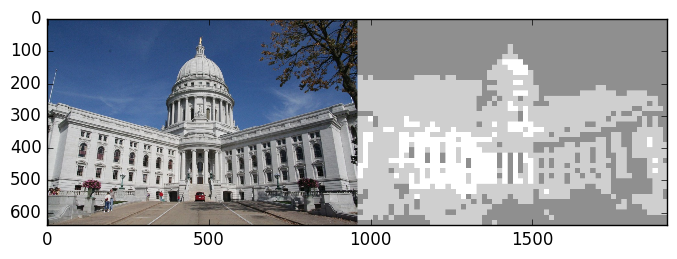

In [12]:
# plot two images side by side to see how we did
λ = 0
mosaic_image = lp_formulation(test_image, images_mat, downscaling, λ)

println("RESULTS:");
println("\t ** Desired Image, Mosaic Image **");
imshow([test_image mosaic_image]);

## 6. Results and discussion ##


## 7. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.

## 8. Bonus: try it yourself ##

1. Put the image url down here.

Customer test image file loaded


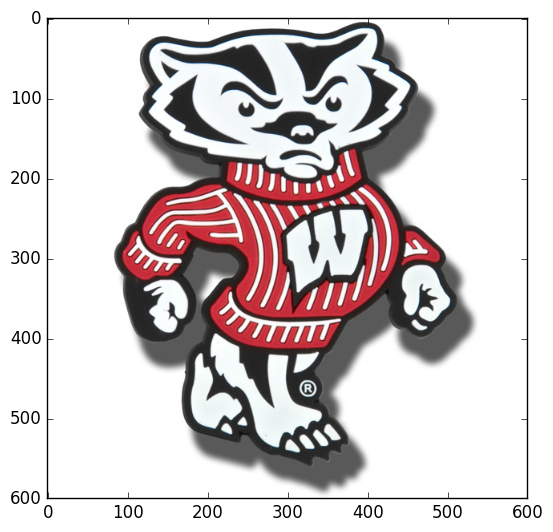

In [79]:
using HTTPClient

img = get("http://wallpaper.zone/img/2789695.jpg")
outfile = open("myimage.jpg", "w")
write(outfile, img.body.data)
close(outfile)
my_image_file = load("./myimage.jpg")
my_image_mat = convert_image_to_mat(my_image_file)
println("Customer test image file loaded")
imshow(my_image_mat);